In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,roc_auc_score,confusion_matrix, classification_report, roc_curve
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
import plotly.express as px
from scikitplot.metrics import plot_roc_curve

In [3]:
def load():
    data = pd.read_csv("diabetes.csv")
    return data

df = load()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
fig = px.histogram(df,
                   x='Age',
                   nbins=10,
                   title='Distribution of Impressions')
fig.show()

In [5]:
fig = px.histogram(df,
                   x='SkinThickness',
                   nbins=10,
                   title='Distribution of Impressions')
fig.show()

In [6]:
fig = px.pie(df, names ='Outcome', title='Outcome')
fig.show()

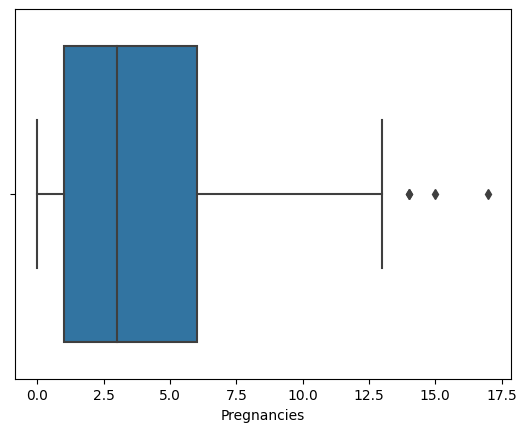

In [7]:
sns.boxplot(x=df["Pregnancies"])
plt.show()

In [8]:
df["Pregnancies"].value_counts()

1     135
0     111
2     103
3      75
4      68
5      57
6      50
7      45
8      38
9      28
10     24
11     11
13     10
12      9
14      2
15      1
17      1
Name: Pregnancies, dtype: int64

In [9]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [10]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [11]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [12]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [13]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [14]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [15]:
grab_outliers(df, "Insulin", True)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
13             1      189             60             23      846  30.1   
228            4      197             70             39      744  36.7   

     DiabetesPedigreeFunction  Age  Outcome  
13                      0.398   59        1  
228                     2.329   31        0  


Int64Index([13, 228], dtype='int64')

In [16]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [17]:
replace_with_thresholds(df, "Insulin")

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.636719,114.242903,0.000,0.00000,30.5000,127.25000,732.50
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [19]:
df.isnull().values.any()

False

Adding Categorical Features

In [20]:
# age level
df.loc[(df['Age'] < 29), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['Age'] >= 29) & (df['Age'] < 41), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['Age'] >= 41), 'NEW_AGE_CAT'] = 'senior'

In [21]:
#BMI
df.loc[(df['BMI'] < 18.5), 'NEW_BMI'] = 'underweight'
df.loc[(df['BMI'] >= 18.5) & (df['BMI'] < 25), 'NEW_BMI'] = 'healthy'
df.loc[(df['BMI'] >= 25) & (df['BMI'] < 30), 'NEW_BMI'] = 'overweight'
df.loc[(df['BMI'] >= 30), 'NEW_BMI'] = 'obese'

In [22]:
df.loc[(df['Pregnancies'] < 3), 'NEW_PREG_CAT'] = 'less'
df.loc[(df['Pregnancies'] >= 3) & (df['Pregnancies'] < 6), 'NEW_PREG_CAT'] = 'normal'
df.loc[(df['Pregnancies'] >= 6), 'NEW_PREG_CAT'] = 'high'

In [23]:
df.loc[(df['BloodPressure'] < 80), 'NEW_BLOOD_CAT'] = 'normal'
df.loc[(df['BloodPressure'] >= 80) & (df['BloodPressure'] < 89), 'NEW_BLOOD_CAT'] = 'high_stage1'
df.loc[(df['BloodPressure'] >= 89) & (df['BloodPressure'] < 120), 'NEW_BLOOD_CAT'] = 'high_stage2'
df.loc[(df['BloodPressure'] >= 120), 'NEW_BLOOD_CAT'] = 'hypertensive_crisis'

In [24]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 13
cat_cols: 5
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [25]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [26]:
rare_analyser(df, "Outcome", cat_cols)

NEW_AGE_CAT : 3
        COUNT     RATIO  TARGET_MEAN
mature    207  0.269531     0.458937
senior    194  0.252604     0.525773
young     367  0.477865     0.193460


NEW_BMI : 4
             COUNT     RATIO  TARGET_MEAN
healthy        102  0.132812     0.068627
obese          472  0.614583     0.463983
overweight     179  0.233073     0.223464
underweight     15  0.019531     0.133333


NEW_PREG_CAT : 3
        COUNT     RATIO  TARGET_MEAN
high      219  0.285156     0.506849
less      349  0.454427     0.246418
normal    200  0.260417     0.355000


NEW_BLOOD_CAT : 4
                     COUNT     RATIO  TARGET_MEAN
high_stage1            145  0.188802     0.420690
high_stage2             59  0.076823     0.491525
hypertensive_crisis      1  0.001302     0.000000
normal                 563  0.733073     0.316163


Outcome : 2
   COUNT     RATIO  TARGET_MEAN
0    500  0.651042          0.0
1    268  0.348958          1.0




In [27]:
#############################################
#One-Hot Encoding
#############################################

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [28]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df = one_hot_encoder(df, ohe_cols)

In [29]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT_mature,...,NEW_BMI_obese,NEW_BMI_overweight,NEW_BMI_underweight,NEW_PREG_CAT_high,NEW_PREG_CAT_less,NEW_PREG_CAT_normal,NEW_BLOOD_CAT_high_stage1,NEW_BLOOD_CAT_high_stage2,NEW_BLOOD_CAT_hypertensive_crisis,NEW_BLOOD_CAT_normal
0,6,148,72,35,0.0,33.6,0.627,50,1,0,...,1,0,0,1,0,0,0,0,0,1
1,1,85,66,29,0.0,26.6,0.351,31,0,1,...,0,1,0,0,1,0,0,0,0,1
2,8,183,64,0,0.0,23.3,0.672,32,1,1,...,0,0,0,1,0,0,0,0,0,1
3,1,89,66,23,94.0,28.1,0.167,21,0,0,...,0,1,0,0,1,0,0,0,0,1
4,0,137,40,35,168.0,43.1,2.288,33,1,1,...,1,0,0,0,1,0,0,0,0,1


In [30]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 23
cat_cols: 15
num_cols: 8
cat_but_car: 0
num_but_cat: 15


In [31]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [32]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT_mature,...,NEW_BMI_obese,NEW_BMI_overweight,NEW_BMI_underweight,NEW_PREG_CAT_high,NEW_PREG_CAT_less,NEW_PREG_CAT_normal,NEW_BLOOD_CAT_high_stage1,NEW_BLOOD_CAT_high_stage2,NEW_BLOOD_CAT_hypertensive_crisis,NEW_BLOOD_CAT_normal
0,0.639947,0.848324,0.149641,0.907270,-0.697537,0.204013,0.468492,1.425995,1,0,...,1,0,0,1,0,0,0,0,0,1
1,-0.844885,-1.123396,-0.160546,0.530902,-0.697537,-0.684422,-0.365061,-0.190672,0,1,...,0,1,0,0,1,0,0,0,0,1
2,1.233880,1.943724,-0.263941,-1.288212,-0.697537,-1.103255,0.604397,-0.105584,1,1,...,0,0,0,1,0,0,0,0,0,1
3,-0.844885,-0.998208,-0.160546,0.154533,0.125808,-0.494043,-0.920763,-1.041549,0,0,...,0,1,0,0,1,0,0,0,0,1
4,-1.141852,0.504055,-1.504687,0.907270,0.773973,1.409746,5.484909,-0.020496,1,1,...,1,0,0,0,1,0,0,0,0,1


In [ ]:
#Defining variables and outcome

In [33]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=17, stratify= y)

In [35]:
#####################
#Logistic Regression#
#####################

log_model = LogisticRegression().fit(X_train, y_train)

In [36]:
#Getting predictions
y_pred = log_model.predict(X_test)

In [37]:
# Possiblity of belonging to first class for AUC Score
y_prob = log_model.predict_proba(X_test)[:, 1]

In [38]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       100
           1       0.74      0.74      0.74        54

    accuracy                           0.82       154
   macro avg       0.80      0.80      0.80       154
weighted avg       0.82      0.82      0.82       154



In [45]:
roc_auc_score(y_test, y_prob)

0.8757407407407407

In [46]:
accuracy_score(y_pred, y_test)

0.8181818181818182

In [47]:
################
#Random Forest
################
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7792207792207793

In [49]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

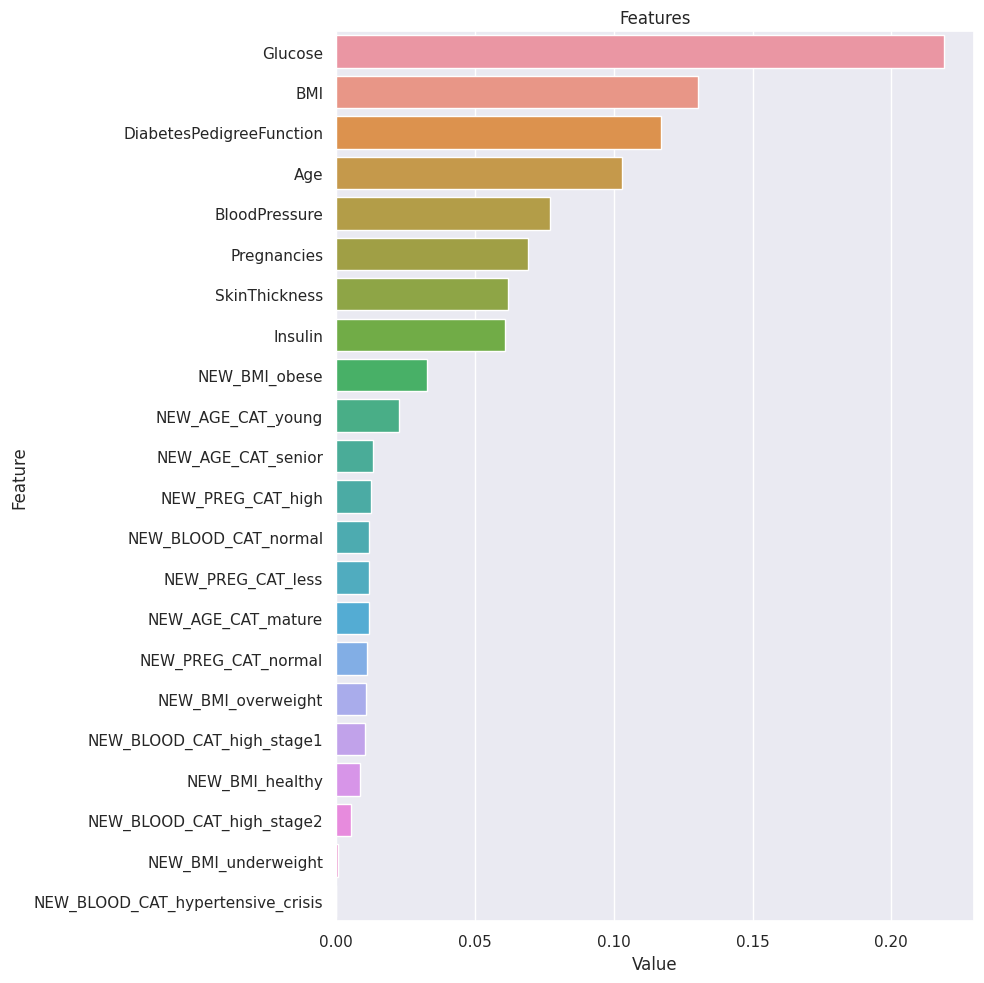

In [51]:
plot_importance(rf_model, X_train, num=30)